## 1. Introduction
We wish to examine and understand what factors contibute towards a customerbooking holidaays with British Airways.

## 2. Dataset and libraries
We begin by setting up our working enviroment by importing the necessary python libraries that we will use throughout the notebook
Then we load and inspect the database to get familiar with its structure and contents.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


## 3. Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking
Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [8]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

The booking_origin column contains different countries which my resemble redudancy every know and then. We choose to convert this countries to continents. This way, we shall have few and coincise fields when the time of encoding approaches.

In [10]:
df['booking_origin'].value_counts()

Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64

In [14]:
!pip install pycountry-convert


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pycountry_convert as pc

continent = []
index = []

df['booking_origin'] =  df['booking_origin'].replace('Myanmar (Burma)', 'Myanmar')

for i in range(len(df)):
    country = df['booking_origin'][i]
    #print(country)
    try :
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent.append(continent_name)
    except:
        continent.append('Others')

df['booking_continent'] = continent

C:\Users\JIMMY\anaconda3\lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
C:\Users\JIMMY\anaconda3\lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [16]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,booking_continent
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,OC
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,OC
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,AS
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,OC
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,AS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0,OC
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0,OC
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0,OC
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0,OC


- AS: Asia
- OC: Oceania
- EU: Europe
- NA: North America
- Others: Other or unclassified territories
- AF: Africa
- SA: South America

In [17]:
df['booking_continent'].value_counts()

AS        29740
OC        18960
EU          578
NA          525
Others       87
AF           69
SA           41
Name: booking_continent, dtype: int64

In [21]:
df.drop('booking_origin', axis=1, inplace=True)

(50000, 14)

In [19]:
df.sample()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,booking_continent
43658,3,Mobile,RoundTrip,41,6,9,4,CNXPEK,0,0,0,6.42,0,AS


## 4. Visualizasion

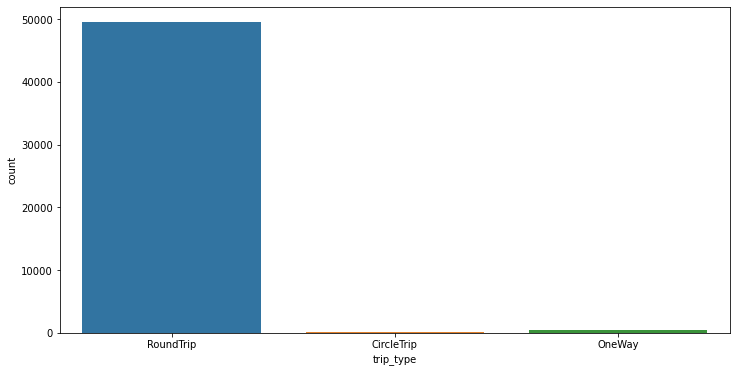

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(x='trip_type', data=df)
plt.show()

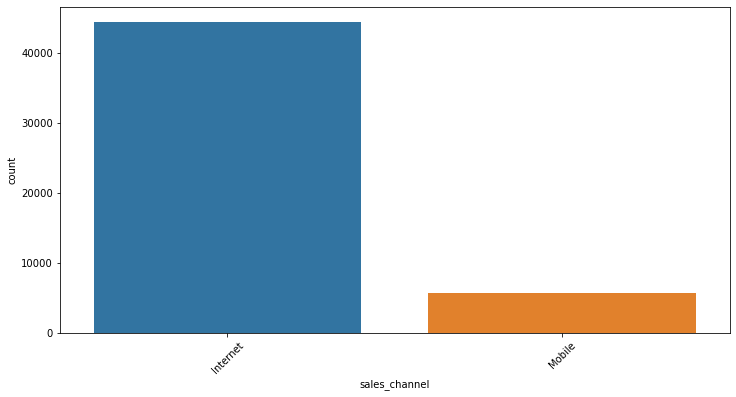

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(x='sales_channel', data=df)
plt.xticks(rotation=45)
plt.show()

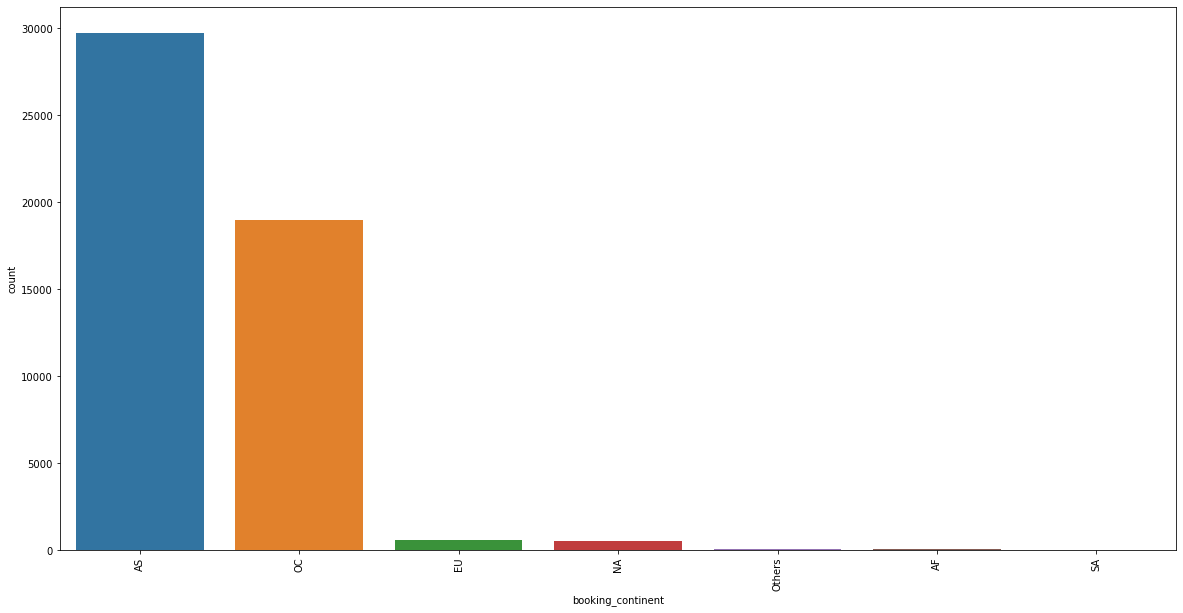

In [26]:
# Get the top 100 booking origins
top_booking_continent = df['booking_continent'].value_counts().head(100).index

# Bar chart for the top 100 booking origins
plt.figure(figsize=(20, 10))
sns.countplot(x='booking_continent', data=df, order=top_booking_continent)
plt.xticks(rotation=90)
plt.show()

## 5. Mutual Infrmation

In [27]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [28]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_continent          int64
dtype: object

In [29]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.051303
booking_continent        0.033673
flight_duration          0.016602
wants_extra_baggage      0.008357
length_of_stay           0.008039
purchase_lead            0.004846
wants_in_flight_meals    0.002160
sales_channel            0.001992
flight_day               0.001510
num_passengers           0.001395
wants_preferred_seat     0.001367
flight_hour              0.000994
trip_type                0.000000
Name: MI Scores, dtype: float64

Mutual Information (MI) scores are a measure of the mutual dependence between two variables. In the context of feature selection in machine learning, MI scores are often used to quantify the relationship between a feature and the target variable. A higher MI score indicates a stronger relationship, suggesting that the feature is more informative for predicting the target variable.

Here are some general rules of thumb for interpreting MI scores:

- `0`: No mutual information. The variables are independent.
- `0 - 0.1`: Weak relationship. The variables have some dependency, but it may not be significant.
- `0.1 - 0.2`: Moderate relationship. The variables have a noticeable dependency.
- `0.2+`: Strong relationship. The variables are highly dependent, suggesting that the feature is informative for predicting the target variable.

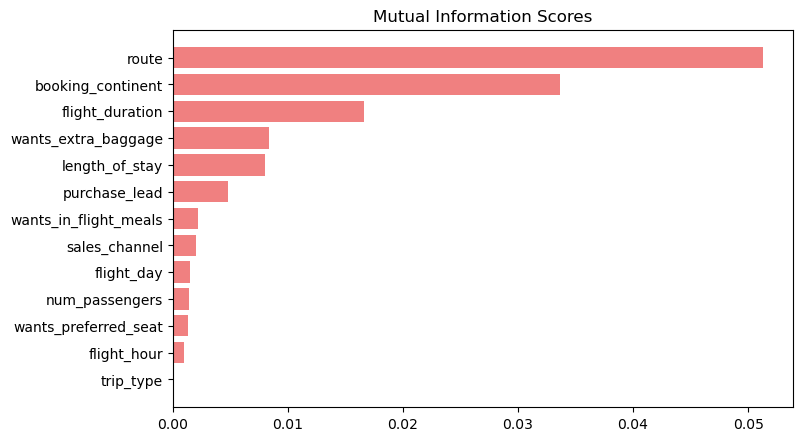

In [32]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color='lightcoral')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

we can notice that route is amonf the top variable that play role in contribution towards a customer booking holiday with British Airways

In [34]:
#test train split
# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

In [35]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

## Model 1 : Random forest classifier with all features

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.83000000000001
AUC score:  0.547286581374679


## Model 2 : XGB classifier with all features

In [45]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete 

X_train,X_val,y_train,y_val= dataset(X,y)


xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.94
AUC score:  0.5286541813376409


Finalizing XGB model with all features as final model, as it has good accuracy and higher auc score compared to other models